# Whitefly Detection

Aluno: Lucas de Almeida Bandeira Macedo

Matrícula: 19/0047089

Este notebook foi construído seguindo o tutorial persente no Medium: [TRAIN A CUSTOM YOLOv4 OBJECT DETECTOR (Using Google Colab)](https://medium.com/p/61a659d4868#a777)

E utiliza a implementação do Yolov4 presente no seguinte repositório: [AlexeyAB/darknet](https://github.com/AlexeyAB/darknet)


In [15]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## Preprocessamento

Este notebook foi feito de forma que o repositório darknet e o dataset sejam subpastas do diretório principal do projeto, ou seja:

- projeto/data
- projeto/darknet
- projeto/main.ipynb
- projeto/data/super_abundance

devem todos serem caminhos válidos. Se atente a organização dos diretórios ao tentar executar esse notebook.

As próximas células de código dizem respeito ao processamento do dataset, com o objetivo que ele se adeque a rede yolov4 importada.

Para isso, são necessários:

- Uma lista de todas as imagens do dataset, em formato txt
- Conversão das anotações de XML para TXT
- Cada anotação na mesma pasta da sua imagem correspondente

In [22]:
data_dir_list = os.listdir("data")
data_dir_list

['low_abundance',
 'moderate_abundance',
 'super_abundance',
 'test.txt',
 'train.txt',
 'valid.txt']

In [21]:
os.getcwd()

'/mnt/c/Users/lucas/Documents/Programacao/Projeto 2'

Código para extrair todas as imagens do dataset, preservando a classificação de abundância

In [23]:
d = {"abundance":[], "img_path": [], "label_path": []}
for data_dir in data_dir_list:
  if len(data_dir.split(".")) != 1: continue # ignora arquivos com extensao (truque barato para evitar diretorios)
  img_file_name_list = os.listdir(f"data/{data_dir}/images")
  lbl_file_name_list = os.listdir(f"data/{data_dir}/annotation")
  for img_path in sorted(img_file_name_list):
    if img_path.split(".")[-1] != "jpg": continue
    d["abundance"].append(data_dir)
    d["img_path"].append(f"{os.getcwd()}/data/{data_dir}/images/{img_path}")
    d["label_path"].append(f"{os.getcwd()}/data/{data_dir}/annotation/{'.'.join(img_path.split('.')[:-1])}.xml")

df = pd.DataFrame(d)
df

abundance                                           img_path  \
0       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
1       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
3       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
4       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
...               ...                                                ...   
2995  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2996  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2997  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2998  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2999  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   

                                             label_path  
0     /mnt/c/Users/lucas/Documents/Programacao/Proje...  
1     /mnt/c/Users/lucas/Documents/Programacao/Proje...  
2     /mnt/c/Users/lucas/Documents/Programacao/Proje...  
3     /mnt/c/Users/lucas/Documents/Programacao/Proje...  
4     /mnt/c/Users/lucas/Documents/Programacao/Proje...  
...                                                 ...  
2995  /mnt/c/Users/lucas/Documents/Programacao/Proje...  
2996  /mnt/c/Users/lucas/Documents/Programacao/Proje...  
2997  /mnt/c/Users/lucas/Documents/Programacao/Proje...  
2998  /mnt/c/Users/lucas/Documents/Programacao/Proje...  
2999  /mnt/c/Users/lucas/Documents/Programacao/Proje...  

[3000 rows x 3 columns]

Aqui é feita a separação treino-validação-teste, com frações de 70% 15% 15%, respectivamente.

O random state garante que não teremos um conjunto de dados diferente para cada vez que esse código for executado

In [33]:
df_valid = df.sample(frac=0.3, random_state=1)
df_test = df_valid.sample(frac=0.5, random_state=1)

df_train = df.drop(df_valid.index).sample(frac=1)
df_valid = df_valid.drop(df_test.index)

df_train.shape, df_valid.shape, df_test.shape

((2100, 4), (450, 4), (450, 4))

Trecho de código para criar os arquivos train.txt, valid.txt, test.txt; contendo a lista de paths para cada imagem

In [6]:
files = ["train", "valid", "test"]
for file, d_df in zip(files, [df_train, df_valid, df_test]):
  f = open(f"data/{file}.txt", "w")
  d_df.img_path.apply(lambda x: f.write(x + "\n"))
  f.close()


O código na célula a seguir foi extraído do seguinte link:

[https://gist.github.com/Amir22010/a99f18ca19112bc7db0872a36a03a1ec](https://gist.github.com/Amir22010/a99f18ca19112bc7db0872a36a03a1ec)

E adaptado para o contexto do projeto

Seu propósito é fazer a conversão da anotação de XML para TXT, no formato que a yolo da darknet consiga utilizar

In [7]:
import xml.etree.ElementTree as ET

classes = ['whitefly']

def convert(size, box):
  dw = 1./(size[0])
  dh = 1./(size[1])
  x = (box[0] + box[1])/2.0 - 1
  y = (box[2] + box[3])/2.0 - 1
  w = box[1] - box[0]
  h = box[3] - box[2]
  x = x*dw
  w = w*dw
  y = y*dh
  h = h*dh
  return (x,y,w,h)

def convert_annotation(output_path, xml_path):
  in_file = open(xml_path)
  out_file = open(output_path, 'w')
  tree = ET.parse(in_file)
  root = tree.getroot()
  size = root.find('size')
  w = int(size.find('width').text)
  h = int(size.find('height').text)

  for obj in root.iter('object'):
    difficult = obj.find('difficult').text
    cls = obj.find('name').text
    if cls not in classes or int(difficult)==1:
        continue
    cls_id = classes.index(cls)
    xmlbox = obj.find('bndbox')
    b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
    bb = convert((w,h), b)
    out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

In [8]:
def a(x):
  out = x.split("/")
  out[-2] = "images"
  name = out[-1].split(".")
  out[-1] = ".".join([name[0], "txt"])
  convert_annotation("/".join(out), x)
  
df.label_path.apply(a)

0       None
1       None
2       None
3       None
4       None
        ... 
2995    None
2996    None
2997    None
2998    None
2999    None
Name: label_path, Length: 3000, dtype: object

## Configurações da Darknet

A seção a seguir tem o propósito de fazer as configurações necessárias no repositório importado darknet.

Precisamos fazer as seguintes alterações:

- Modificar o Makefile do repositório para incluir aceleração CUDA e CUDNN
- Inserir nossa configuração personalizada da rede Yolo, junto com os arquivos de configuração

A célula a seguir faz a alteração no Makefile

In [1]:
############################
# Windows ou Linux

# f = open("./darknet/Makefile", "r")
# content = f.read()
# f.close()

# content = re.sub(r"GPU=0", "GPU=1", content)
# content = re.sub(r"CUDNN=0", "CUDNN=1", content)
# content = re.sub(r"CUDNN_HALF=0", "CUDNN_HALF=1", content)
# content = re.sub(r"OPENCV=0", "OPENCV=1", content)
# content = re.sub(r"LIBSO=0", "LIBSO=1", content)

# f = open("./darknet/Makefile", "w")
# f.write(content)
# f.close()

###########################
# Apenas Linux

%cd darknet/
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet


In [2]:
# !make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 0)
      |

Limpa a pasta `data` e `cfg` do repositório

In [3]:
%cd data/
!find -maxdepth 1 -type f -exec rm -rf {} \;
%cd ..

%rm -rf cfg/
%mkdir cfg

%cd ..

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet/data
/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet
/mnt/c/Users/lucas/Documents/Programacao/Projeto 2


Copia os arquivos de configuração para a pasta correta

In [4]:
!cp yolov4-custom.cfg darknet/cfg
!cp obj.names darknet/data
!cp obj.data  darknet/data

%cd darknet

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet


## Treinamento

Para o treinamento, basta executar a função compilada, passando as configurações e os pesos necessários

Baixa os pesos da yolov4 para realizar transferência de aprendizado

In [5]:
#!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

Código para treinar com transferência de aprendizado (pesos da yolov4)

In [ ]:
# !./darknet detector train data/obj.data cfg/yolov4-custom.cfg training/yolov4.conv.137 -dont_show -map

Código para continuar treinamento anterior (com o último conjunto salvo de pesos)

In [6]:
# !./darknet detector train data/obj.data cfg/yolov4-custom.cfg training/yolov4-custom_last.weights -dont_show -map

## Testes

In [2]:
%cd darknet

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet


Carrega as configurações de teste (que são diferentes das configurações de treino) para obter as marcações:

In [3]:
!cp ../test.cfg cfg/yolov4-custom.cfg

As duas próximas celulas fazem o teste em apenas uma imagem, obtendo as marcações geradas

In [5]:
def imShow(path):
  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)
  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

 CUDA-version: 11070 (11070), cuDNN: 8.5.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: NVIDIA GeForce GTX 1060 6GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    480 x 480 x   3 ->  480 x 480 x  32 0.398 BF
   1 conv     64       3 x 3/ 2    480 x 480 x  32 ->  240 x 240 x  64 2.123 BF
   2 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   3 route  1 		                           ->  240 x 240 x  64 
   4 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   5 conv     32       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  32 0.236 BF
   6 conv     64       3 x 3/ 1    240 x 240 x  32 ->  240 x 240 x  64 2.123 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 240 x 240 x  64 0.

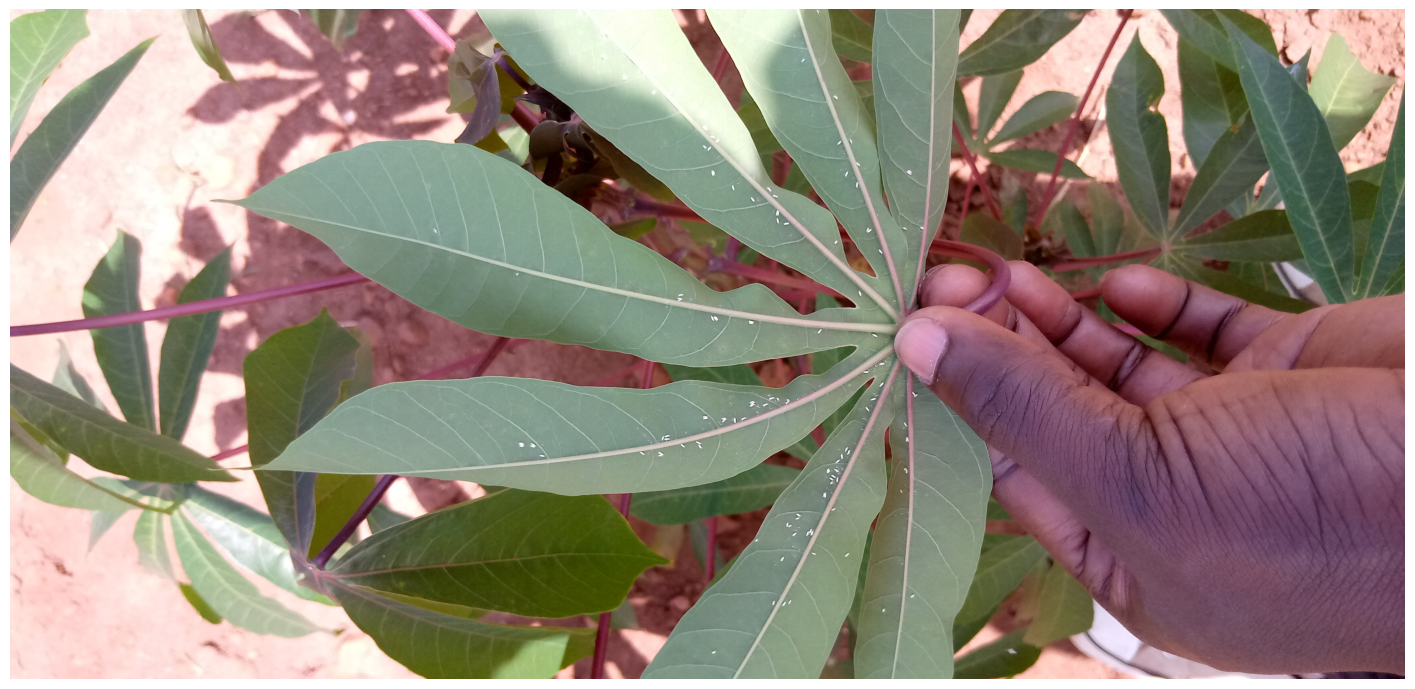

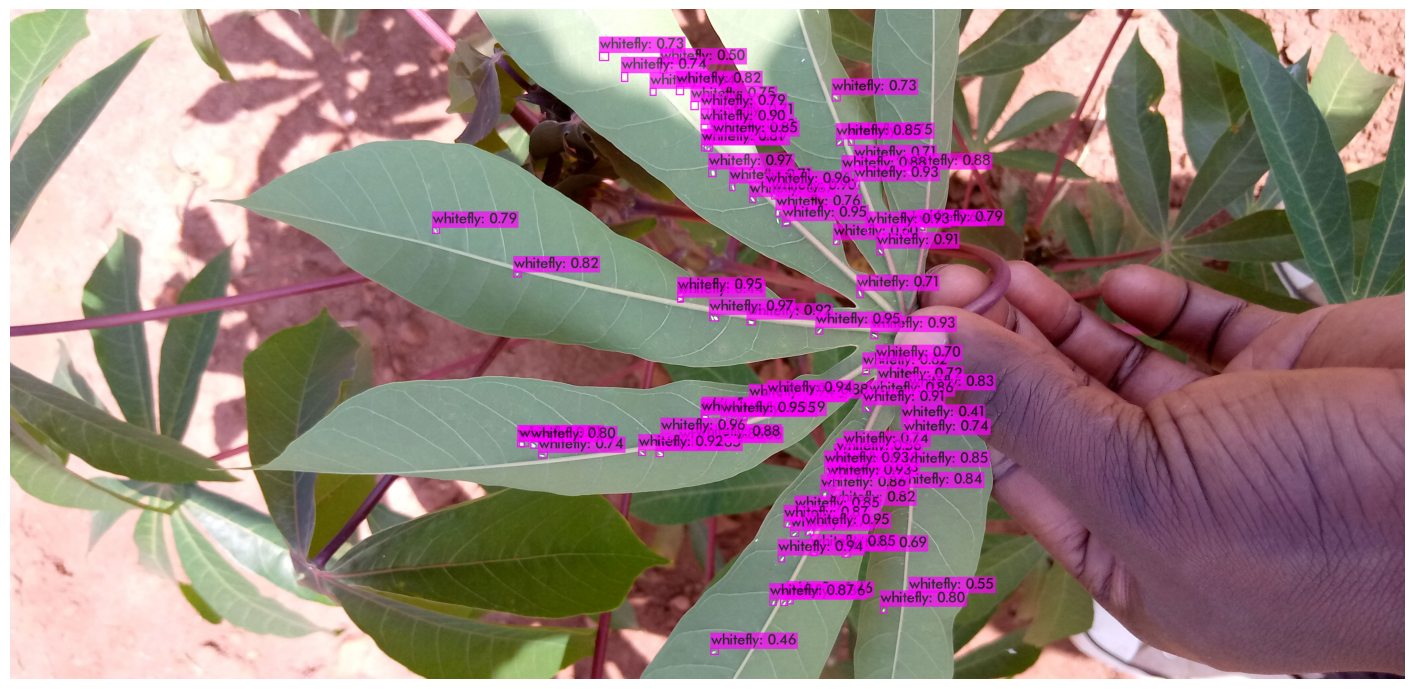

In [12]:
img_test_path = "../data/super_abundance/images/IMG_20190304_235751_1.jpg"
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg training/yolov4-custom_best.weights $img_test_path -thresh 0.3
imShow(img_test_path)
imShow('predictions.jpg')

In [14]:
!./darknet detector map data/obj.data cfg/yolov4-custom.cfg training/yolov4-custom_best.weights -points 0

 CUDA-version: 11070 (11070), cuDNN: 8.5.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: NVIDIA GeForce GTX 1060 6GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    480 x 480 x   3 ->  480 x 480 x  32 0.398 BF
   1 conv     64       3 x 3/ 2    480 x 480 x  32 ->  240 x 240 x  64 2.123 BF
   2 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   3 route  1 		                           ->  240 x 240 x  64 
   4 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   5 conv     32       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  32 0.236 BF
   6 conv     64       3 x 3/ 1    240 x 240 x  32 ->  240 x 240 x  64 2.123 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 240 x 240 x  64 0.

Resultados relevantes obtidos:

- F1-Score: 0.63
- Precision: 0.67
- Recall: 0.60
- MAP (mean average precision): 0.475725

## Análise do resultado obtido

0.63 na F1-Score é, no geral, uma pontuação bem aceitável, principalmente na área de detecção de objetos. Mas claro que poderia ser muito melhor.

O melhor jeito de ter uma real estimativa do quão bom é determinada pontuação é comparar com outros modelos que trabalharam em cima do mesmo dataset, com os mesmos objetivos. Assim, comparamos com o trabalho de TUSUBIRA, Jeremy Francis, que trabalha no mesmo problema em seu trabalho "Improving in-field cassava whitefly pest surveillance with machine learning"

Lá, Tusubira consegue as seguintes métricas:

- Precision: 0.98
- Recall: 0.81
- F1 Score: 0.89

Podemos observar, imediatamente, que o modelo aqui atingido não se compara ao do Tusubira. Mas isso significa que a arquitetura proposta, Faster-RCNN, é melhor que a arquitetura Yolov4? Não necessariamente

Existem algumas melhorias que consigo apontar de imediato, e que provavelmente trariam um desempenho melhor na rede resultante:

- Existem 194 casos em que há mais de 200 moscas brancas em determinada imagem, e uma das configurações de treinamento da rede especifica que o máximo é 200. Isso pode ter causado uma queda nas métricas atingidas.
- Por limitação de hardware, o treinamento foi feito com imagens redimensionadas para 480x480. As moscas são pequenas, portanto, um redimensionamento grande pode acabar removendo muita informação relevante da imagem.
- Por limitação de tempo, a rede final foi gerada com apenas 3000 iterações. Ela estava, antes do fim do treinamento, constantemente melhorando e aprendendo. Portanto, imagino que mais iterações levaria a pontuações maiores.
- Existem 29 imagens que tiveram suas labels corrompidas (o arquivo txt estava erroneamente vazio) e provavelmente atrapalharam o treinamento.

Consertando esses problemas, conseguiríamos uma performance maior.

## Classificação de Severidade

Para finalizar, vamos fazer a classificação de acordo com o número de moscas brancas (entre as classes low_abundance, moderate_abundance e super_abundance)

In [ ]:
%cd ..

Extrair número de moscas brancas do dataset rotulado

In [92]:
def get_number_of_flies(path):
  txt_path = ".".join(path.split(".")[:-1]) + ".txt"
  f = open(txt_path, "r")
  num_of_flies = len(f.readlines())
  f.close()
  return num_of_flies

df_train["number_of_flies"] = df_train.img_path.apply(get_number_of_flies)
df_valid["number_of_flies"] = df_valid.img_path.apply(get_number_of_flies)
df_test["number_of_flies"] = df_test.img_path.apply(get_number_of_flies)
df["number_of_flies"] = df.img_path.apply(get_number_of_flies)

df

abundance                                           img_path  \
0       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
1       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
3       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
4       low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
...               ...                                                ...   
2995  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2996  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2997  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2998  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2999  super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   

                                             label_path  number_of_flies  
0     /mnt/c/Users/lucas/Documents/Programacao/Proje...                6  
1     /mnt/c/Users/lucas/Documents/Programacao/Proje...                5  
2     /mnt/c/Users/lucas/Documents/Programacao/Proje...                1  
3     /mnt/c/Users/lucas/Documents/Programacao/Proje...                5  
4     /mnt/c/Users/lucas/Documents/Programacao/Proje...                4  
...                                                 ...              ...  
2995  /mnt/c/Users/lucas/Documents/Programacao/Proje...              114  
2996  /mnt/c/Users/lucas/Documents/Programacao/Proje...              235  
2997  /mnt/c/Users/lucas/Documents/Programacao/Proje...              113  
2998  /mnt/c/Users/lucas/Documents/Programacao/Proje...              184  
2999  /mnt/c/Users/lucas/Documents/Programacao/Proje...              162  

[3000 rows x 4 columns]

Análise dos limites das classes (lembrando que existem imagens com suas labels corrompidas)

In [67]:
def min_max_flies(df, criteria):
  df_temp = df[df.abundance == criteria]
  return df_temp.number_of_flies.min(), df_temp.number_of_flies.max(), criteria

print(min_max_flies(df, 'low_abundance'))
print(min_max_flies(df, 'moderate_abundance'))
print(min_max_flies(df, 'super_abundance'))

(0, 9, 'low_abundance')
(0, 99, 'moderate_abundance')
(0, 613, 'super_abundance')


Classificador determinístico, baseado nas informações do dataset

In [56]:
def abundance_classifier(number_of_flies):
  if number_of_flies <= 9:
    return "low_abundance"
  elif number_of_flies >= 100:
    return "super_abundance"
  else:
    return "moderate_abundance"

Realiza detecção com os pesos obtidos

In [84]:
%cd darknet
!./darknet detector test data/obj.data cfg/yolov4-custom.cfg training/yolov4-custom_best.weights -thresh 0.3 -dont_show -save_labels < ../data/test.txt
%cd ..

/mnt/c/Users/lucas/Documents/Programacao/Projeto 2/darknet
 CUDA-version: 11070 (11070), cuDNN: 8.5.0, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 4.2.0
 0 : compute_capability = 610, cudnn_half = 0, GPU: NVIDIA GeForce GTX 1060 6GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    480 x 480 x   3 ->  480 x 480 x  32 0.398 BF
   1 conv     64       3 x 3/ 2    480 x 480 x  32 ->  240 x 240 x  64 2.123 BF
   2 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   3 route  1 		                           ->  240 x 240 x  64 
   4 conv     64       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  64 0.472 BF
   5 conv     32       1 x 1/ 1    240 x 240 x  64 ->  240 x 240 x  32 0.236 BF
   6 conv     64       3 x 3/ 1    240 x 240 x  32 ->  240 x 240 x  64 2.123 BF
   7 Shor

As prediçoes estão sobreescrevendo as antigas labels. Portanto, basta utilizar a mesma função que utilizamos antes

In [85]:
df_test["predictions"] = df_test.img_path.apply(get_number_of_flies)
df_test

abundance                                           img_path  \
993        low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
1060  moderate_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
1992  moderate_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2771     super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
1680  moderate_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
...                  ...                                                ...   
2855     super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
1655  moderate_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
2664     super_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
124        low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   
802        low_abundance  /mnt/c/Users/lucas/Documents/Programacao/Proje...   

                                             label_path  number_of_flies  \
993   /mnt/c/Users/lucas/Documents/Programacao/Proje...                4   
1060  /mnt/c/Users/lucas/Documents/Programacao/Proje...               19   
1992  /mnt/c/Users/lucas/Documents/Programacao/Proje...               57   
2771  /mnt/c/Users/lucas/Documents/Programacao/Proje...              109   
1680  /mnt/c/Users/lucas/Documents/Programacao/Proje...               25   
...                                                 ...              ...   
2855  /mnt/c/Users/lucas/Documents/Programacao/Proje...              156   
1655  /mnt/c/Users/lucas/Documents/Programacao/Proje...               36   
2664  /mnt/c/Users/lucas/Documents/Programacao/Proje...              137   
124   /mnt/c/Users/lucas/Documents/Programacao/Proje...                8   
802   /mnt/c/Users/lucas/Documents/Programacao/Proje...                2   

      predictions  
993             4  
1060           11  
1992           54  
2771           97  
1680           46  
...           ...  
2855          135  
1655           23  
2664          137  
124             8  
802             1  

[450 rows x 5 columns]

Realiza a classificação

In [90]:
predictions = df_test.predictions.apply(abundance_classifier).values

Avaliação

In [91]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

print(classification_report(df_test.abundance.values, predictions))

                    precision    recall  f1-score   support

     low_abundance       0.95      0.96      0.96       162
moderate_abundance       0.83      0.95      0.89       147
   super_abundance       1.00      0.84      0.92       141

          accuracy                           0.92       450
         macro avg       0.93      0.92      0.92       450
      weighted avg       0.93      0.92      0.92       450



Como resultado final obtivemos um modelo com ótimas métricas.

Claro que isso não representa, por completo, a qualidade da rede yolo produzida. Afinal, as classes de abundância contemplam um alcance de dados muito grande, sendo que podemos errar por mais de 200 moscas em alguns dados, e podemos ainda cair dentro da classe correta.